In [1]:
from model import *

x_good = torch.tensor([[1., 0.]])
x_bad = torch.tensor([[0., 1.]])

def recover_params_with_probs_with_x(good_probs, bad_probs):
    theta = torch.randn(2, 3, requires_grad=True)
    learning_rate = 0.1
    num_iterations = 8000
    
    good_probs = torch.tensor(good_probs)
    bad_probs = torch.tensor(bad_probs)
    
    for _ in tqdm(range(num_iterations)):
        pred_good_probs = F.softmax(x_good.matmul(theta), -1).squeeze()
        pred_bad_probs = F.softmax(x_bad.matmul(theta), -1).squeeze()

        loss = torch.mean((pred_good_probs - good_probs) ** 2 + (pred_bad_probs - bad_probs) ** 2)
        loss.backward()
        with torch.no_grad():
            theta -= learning_rate*theta.grad
        theta.grad.zero_()
    return theta.data.cpu().numpy().tolist()


pi_star_good_probs = [0.6, 0.3, 0.1]
# pi_star_bad_probs = [0.4, 0.2, 0.4]
pi_star_bad_probs = [0.6, 0.2, 0.2]

random.seed(99)

data_good = generate_data(pi_star_good_probs, 200)
data_bad = generate_data(pi_star_bad_probs, 200)
print(len(data_good), len(data_bad))

preservation_data = [(x[0], x[1], x_good) for x in data_good] + [(x[0], x[1], x_bad) for x in data_bad]
# preservation_data = [(x[0], x[1], x_good) for x in data_good]
random.shuffle(preservation_data)
print(len(preservation_data))


# ref_bad_probs = [0.6, 0.2, 0.2]
ref_bad_probs = [0.4, 0.2, 0.4]
ref_theta_with_x = recover_params_with_probs_with_x(pi_star_good_probs, ref_bad_probs)
print(F.softmax(x_good.matmul(torch.tensor(ref_theta_with_x)), -1))
print(F.softmax(x_bad.matmul(torch.tensor(ref_theta_with_x)), -1))

141 136
277


100%|██████████| 8000/8000 [00:01<00:00, 4145.64it/s]

tensor([[0.6000, 0.3000, 0.1000]])
tensor([[0.4000, 0.2000, 0.4000]])


In [2]:
import warnings
warnings.filterwarnings("ignore")

log_lambdas = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
batch_size=1

preservation_dpo_policy = []
preservation_ipo_policy = []
preservation_fdpo_policy = []
for v in log_lambdas:
    print(v)
    preservation_dpo_policy.append(train(preservation_data, ref_theta_with_x, 'dpo', np.exp(v), num_epochs=50, lr=1e-3, batch_size=batch_size)[0])
    preservation_ipo_policy.append(train(preservation_data, ref_theta_with_x, 'ipo', np.exp(v), num_epochs=50, lr=1e-3, batch_size=batch_size)[0])
    preservation_fdpo_policy.append(train(preservation_data, ref_theta_with_x, 'f-dpo', np.exp(v), num_epochs=100, lr=1e-3, batch_size=batch_size)[0])

-5
Training dpo


Training ipo
Training f-dpo
-4
Training dpo
Training ipo
Training f-dpo
-3
Training dpo
Training ipo
Training f-dpo
-2
Training dpo
Training ipo
Training f-dpo
-1
Training dpo
Training ipo
Training f-dpo
0
Training dpo
Training ipo
Training f-dpo
1
Training dpo
Training ipo
Training f-dpo
2
Training dpo
Training ipo
Training f-dpo
3
Training dpo
Training ipo
Training f-dpo
4
Training dpo
Training ipo
Training f-dpo
5
Training dpo
Training ipo
Training f-dpo


In [3]:
preservation_expo_policy = []
for v in log_lambdas:
    print(v)
    preservation_expo_policy.append(train(preservation_data, ref_theta_with_x, 'expo', np.exp(v), num_epochs=200, lr=5e-4, batch_size=batch_size)[0])

-5
Training expo


-4
Training expo
-3
Training expo
-2
Training expo
-1
Training expo
0
Training expo
1
Training expo
2
Training expo
3
Training expo
4
Training expo
5
Training expo


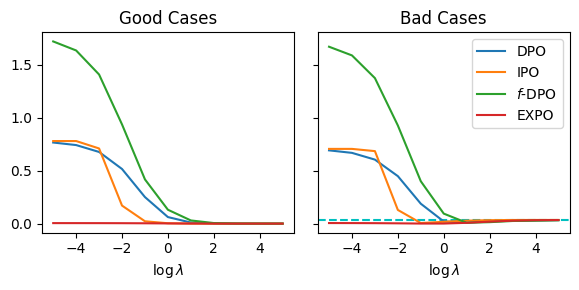

In [4]:
def prob_dist(probs1, probs2, type='kl'):
    probs1 = torch.tensor(probs1)
    probs2 = torch.tensor(probs2)
    
    if type == 'kl':
        d = F.kl_div(torch.log(probs2), torch.log(probs1), log_target=True)
        # d = F.kl_div(torch.log(probs1), torch.log(probs2), log_target=True)
    
    # d = ((probs1 - probs2) ** 2).sum().sqrt().item()
    
    return d

def get_probs(pi, x):
    pi = pi.cpu()
    probs = F.softmax(torch.tensor(x).matmul(torch.tensor(pi)), -1).squeeze()
    return probs.data.numpy().tolist()

dpo_good_dists = [prob_dist(pi_star_good_probs, get_probs(pi, x_good)) for pi in preservation_dpo_policy]
dpo_bad_dists = [prob_dist(pi_star_bad_probs, get_probs(pi, x_bad)) for pi in preservation_dpo_policy]
dpo_bad_dists_to_ref = [prob_dist(ref_bad_probs, get_probs(pi, x_bad)) for pi in preservation_dpo_policy]

ipo_good_dists = [prob_dist(pi_star_good_probs, get_probs(pi, x_good)) for pi in preservation_ipo_policy]
ipo_bad_dists = [prob_dist(pi_star_bad_probs, get_probs(pi, x_bad)) for pi in preservation_ipo_policy]
ipo_bad_dists_to_ref = [prob_dist(ref_bad_probs, get_probs(pi, x_bad)) for pi in preservation_ipo_policy]

fdpo_good_dists = [prob_dist(pi_star_good_probs, get_probs(pi, x_good)) for pi in preservation_fdpo_policy]
fdpo_bad_dists = [prob_dist(pi_star_bad_probs, get_probs(pi, x_bad)) for pi in preservation_fdpo_policy]
fdpo_bad_dists_to_ref = [prob_dist(ref_bad_probs, get_probs(pi, x_bad)) for pi in preservation_fdpo_policy]

expo_good_dists = [prob_dist(pi_star_good_probs, get_probs(pi, x_good)) for pi in preservation_expo_policy]
expo_bad_dists = [prob_dist(pi_star_bad_probs, get_probs(pi, x_bad)) for pi in preservation_expo_policy]
expo_bad_dists_to_ref = [prob_dist(ref_bad_probs, get_probs(pi, x_bad)) for pi in preservation_expo_policy]


ref_dist = prob_dist(pi_star_bad_probs, ref_bad_probs)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, sharey='row', figsize=(6, 3))

ax[0].set_title('Good Cases')
# ax[0].set_ylabel('dist$[\pi^*(y|x), \pi_{\\theta}(y|x)]$')
ax[0].set_xlabel('$\log{\lambda}$')
ax[0].plot(log_lambdas, dpo_good_dists, label='DPO')
ax[0].plot(log_lambdas, ipo_good_dists, label='IPO')
ax[0].plot(log_lambdas, fdpo_good_dists, label='$f$-DPO')
ax[0].plot(log_lambdas, expo_good_dists, label='EXPO')
# ax[0].set_xticks(log_lambdas)

ax[1].set_title('Bad Cases')
ax[1].set_xlabel('$\log{\lambda}$')
ax[1].axhline(ref_dist, linestyle='--', color='c')
ax[1].plot(log_lambdas, dpo_bad_dists, label='DPO')
ax[1].plot(log_lambdas, ipo_bad_dists, label='IPO')
ax[1].plot(log_lambdas, fdpo_bad_dists, label='$f$-DPO')
ax[1].plot(log_lambdas, expo_bad_dists, label='EXPO')


# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
# fig.suptitle('Preservation Test: Converged $\pi_{\\theta}(y)$ by Varying $\lambda$', fontsize=14, y=0.96)
plt.tight_layout()
# plt.show()
plt.savefig('toy_exp_preservation_1.pdf', dpi=300)